# **Imports**

In [ ]:
# If using google colab
# Run the following codes

# Mount google drive
#from google.colab import drive
#drive.mount('/content/drive')
#!pip install -r "/content/drive/MyDrive/~/requirements.txt" # Replace with the path to your requirements.txt file
#from google.colab.patches import cv2_imshow 
#from google.colab import drive

In [29]:
import pandas as pd
import numpy as np
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
import keras.metrics

from collections import Counter
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Input
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

# **Helper functions**

In [5]:
def onehot(y):

  y_onehot = []

  for i in y.to_numpy():
    if i == 1: y_onehot.append([0, 1])
    else: y_onehot.append([1, 0])

  y_onehot = np.array(y_onehot)

  return y_onehot
  
def import_database(dir):

  with open(dir, "rb") as file:
    data = []
    for i in range(0, 2):
       #with open(dir, "rb") as file:
        data.append(pickle.load(file))

  return data[0], data[1]

def myconfusion_matrix(y_true, y_pred):
  tp, tn, fp, fn = 0, 0, 0, 0

  for i in range(0, len(y_true)):
    if y_pred[i] == y_true[i]:
      if y_pred[i] == 0:
        tn = tn + 1
      else:
        tp = tp + 1
    else:
      if y_pred[i] == 0:
        fn = fn + 1
      else:
        fp = fp + 1

  return tp, tn, fp, fn

# Calculates metrics: accuracy, recall, precision, f1_score, and specificity
def myaccuracy(y_true, y_pred):
    tp, tn, fp, fn = myconfusion_matrix(y_true, y_pred)
    if (tp + tn + fp + fn) == 0: return 0
    return (tp + tn) / (tp + tn + fp + fn)

def myrecall(y_true, y_pred):
    tp, tn, fp, fn = myconfusion_matrix(y_true, y_pred)
    if (tp + fn) == 0: return 0
    return tp / (tp + fn)

def myprecision(y_true, y_pred):
    tp, tn, fp, fn = myconfusion_matrix(y_true, y_pred)
    if (tp + fp) == 0: return 0
    return tp / (tp + fp)

def myf1_score(y_true, y_pred):
    tp, tn, fp, fn = myconfusion_matrix(y_true, y_pred)
    denom = (myprecision(y_true, y_pred) + myrecall(y_true, y_pred))
    if denom == 0: return 0
    return 2 * (myprecision(y_true, y_pred) * myrecall(y_true, y_pred)) / denom

def myspecificity(y_true, y_pred):
    tp, tn, fp, fn = myconfusion_matrix(y_true, y_pred)
    if (tn + fp) == 0: return 0
    return tn / (tn + fp)

# **Congential Syphilis**

## Import data set

In [8]:

dir = 'datasets/images/Syphilis_tsne_34x34.pkl'

X_train, X_test = import_database(dir)

y_train = pd.read_csv('datasets/labels/y_train.csv', sep=';')
y_test = pd.read_csv('datasets/labels/y_test.csv', sep=';')

enc = OneHotEncoder(categories='auto', sparse_output=False)

y_train = enc.fit_transform(y_train)
y_test = enc.transform(y_test)

In [9]:
# Transforming in grayscale

X_train = tf.image.rgb_to_grayscale(X_train)
X_test = tf.image.rgb_to_grayscale(X_test)

In [10]:
shapes = pd.DataFrame(
    {

      "Train": [X_train.shape, y_train.shape],
      "Test": [X_test.shape, y_test.shape],
    }, index=['x', 'y']
)

shapes

,Train,Test
x,"(1321, 34, 34, 1)","(331, 34, 34, 1)"
y,"(1321, 2)","(331, 2)"


In [11]:
print(Counter(np.argmax(y_train, axis=1)))
print(Counter(np.argmax(y_test, axis=1)))

Counter({np.int64(1): 661, np.int64(0): 660})
Counter({np.int64(0): 166, np.int64(1): 165})


## Tuned CNN

In [20]:
# CNN tuned Arquitecture

def build_model(hp):

  model = Sequential()

  model.add(Input(X_train[0].shape))

  for i in range(hp.Int("N_conv_layers", 1, 5, 1)):
    model.add(
        Conv2D(filters=hp.Int(f"Conv_{i}_units", 32, 256, 32),
               kernel_size=3,
               strides=hp.Choice('Strides', [1, 3]),
               padding='same',
               activation="relu"))
    model.add(MaxPooling2D(pool_size=2, strides=1, padding="same"))

  model.add(Flatten())

  for i in range(hp.Int("N_dense_layers", 1, 5, 1)):
    model.add(Dense(hp.Int(f"Dense_{i}_units", 5, 10, 5), activation="relu"))

  model.add(Dense(2, activation="sigmoid"))

  model.compile(
      optimizer=hp.Choice('Optimzer', ['SGD', 'RMSprop', 'Adam']),
      loss="binary_crossentropy",
      metrics=["binary_accuracy"]
  )

  return model

In [21]:
# Initialize tuner
tuner = kt.RandomSearch(
    build_model,
    objective = "val_binary_accuracy",
    max_trials = 1000,
    overwrite=False,
    directory='Keras_Tuner_logs/',
    project_name='tuned_deepinsight_cong_syphilis_34_34'
)

Reloading Tuner from Keras_Tuner_logs/tuned_deepinsight_cong_syphilis_34_34\tuner0.json


In [ ]:
# Search hyperparameter space
tuner.search(
    X_train,
    y_train,
    epochs=10,
    validation_split=0.1,
    shuffle=True
)

In [14]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)
best_hyperparameters

In [ ]:
dir = 'Deepinsight_tuned_cong_syphilis.pkl'

with open(dir, 'rb') as file:
  model = pickle.load(file)

In [23]:
# Get best model
model = tuner.get_best_models(num_models=1)
model = model[0]
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 2, 2, 160)      │       184,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 160)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 1, 1, 128)      │       184,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 445,071 (1.70 MB)

 Trainable params: 445,071 (1.70 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Run the model for 200 epochs and get the best epoch based on validation accuracy

history = model.fit(X_train, y_train, epochs=200, validation_split=0.1, shuffle=True, verbose=0)

val_acc_per_epoch = history.history['val_binary_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch))

Best epoch: 19


In [25]:
# Save model
dir = 'models/Deepinsight_tuned_cong_syphilis_.pkl'

with open(dir, 'wb') as file:
  pickle.dump(model, file)

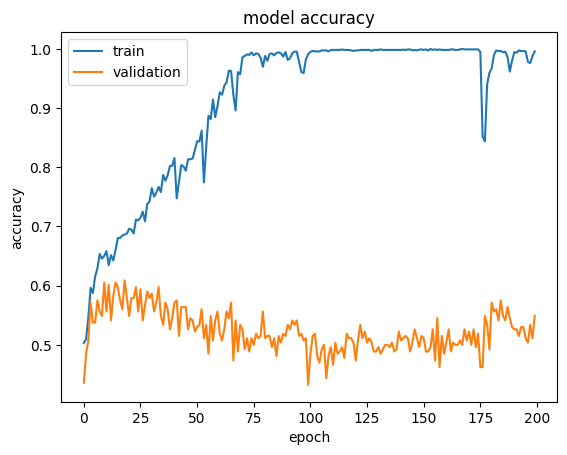

In [26]:
# Plot training graph 
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

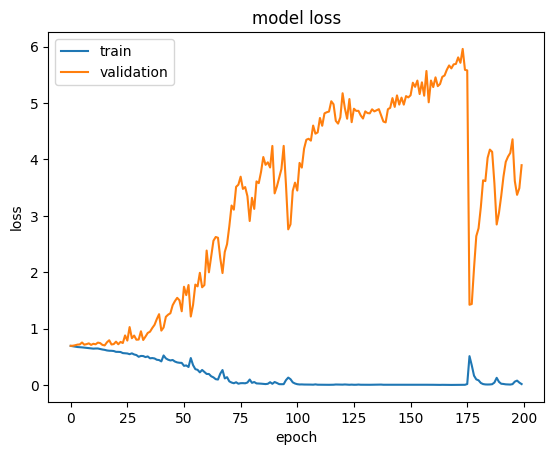

In [31]:
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


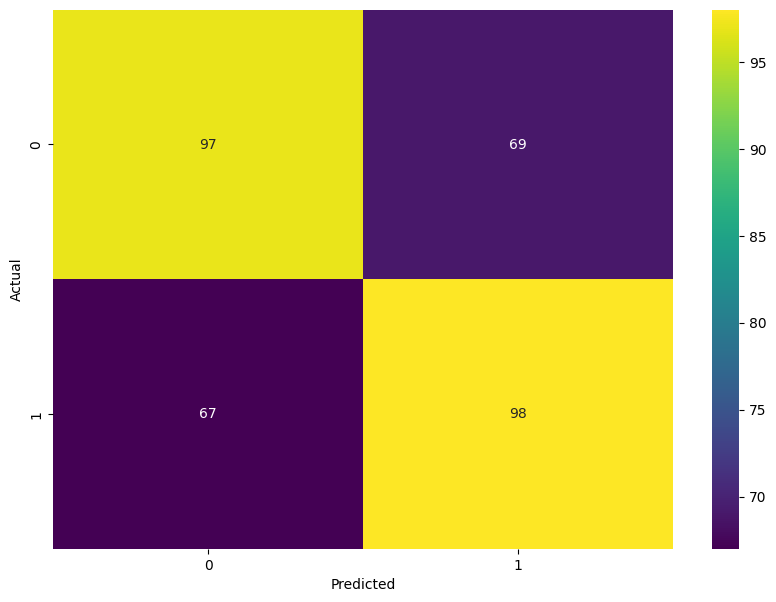

In [30]:
# Plot confusion matrix

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Redefining specificity beacause 1=negative, 0=positive
def myspecificity(y_true, y_pred):
    tp, tn, fp, fn = myconfusion_matrix(y_true, y_pred)
    if (tn + fp) == 0: return 0
    return tp / (tp + fn)

In [ ]:
#Gerando o relatorio dos experimentos
mydados_relatorio_modelo = []

header_dados_relatorio_modelo = ['acc', 'recall', 'precision', 'f1_score', 'specificity']

y_true = [np.argmax(x) for x in y_test]

for exp in range(0, 30):

    model.fit(X_train, y_train, epochs=best_epoch, verbose=0)

    y_pred = model.predict(X_test)
    y_pred = [np.argmax(x) for x in y_pred]

    # Based on my confusion matrix
    tp, tn, fp, fn = myconfusion_matrix(y_true, y_pred)

    my_accuracy = accuracy_score(y_true, y_pred)
    my_recall = recall_score(y_true, y_pred, average='binary', pos_label=0)
    my_precision = precision_score(y_true, y_pred, average='binary', pos_label=0)
    my_f1_score = f1_score(y_true, y_pred, average='binary', pos_label=0)
    my_specificity = myspecificity(y_true, y_pred)

    # Metrics

    # My confusionmatrix
    mydados_relatorio_modelo.append([my_accuracy, my_recall, my_precision, my_f1_score, my_specificity])

# Saving metrics in a datframe
mydados_relatorio_modelo_df = pd.DataFrame(mydados_relatorio_modelo, columns=header_dados_relatorio_modelo)

11/11 [==============================] - 0s 2ms/step


In [ ]:
final_report = pd.DataFrame(mydados_relatorio_modelo_df.mean(axis=0))

In [ ]:
final_report

,0
acc,0.613394
recall,0.553815
precision,0.631220
f1_score,0.588717
specificity,0.553815


## Saving normal results

In [ ]:
# Save results

report_dir = 'Results/Deepinsight_tuned_cong_syphilis_report.csv'
final_dir = 'Results/Deepinsight_tuned_cong_syphilis_mean.csv'

mydados_relatorio_modelo_df.to_csv(report_dir, sep=';')
final_report.to_csv(final_dir, sep=';')

# Save model

dir = 'models/Deepinsight_tuned_cong_syphilis.pkl'

with open(dir, 'wb') as file:
  pickle.dump(model, file)

In [ ]:
model.summary(expand_nested=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 12, 12, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 160)         184480    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 160)        0

In [ ]:
model.get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 34, 34, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'}},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 64,
    'kernel_size': (3, 3),
    'strides': (3, 3),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'MaxPooling2D',
   'config': {'name': 'max_pooling2d',
    'trainable': True,
    'dtype': 'float32',
    'pool_size': (2, 2),
    'pad